# Limits of neural networks
The Achilles' heel of many neural network solutions is improper and/or incomplete training. In this lab, we'll study the effects of training on a neural network with a problem for which we know the solution. Throughout this assignment, the string "..." indicates a detail you need to fill in, within the confines of "# BEGIN SOLUTION" to "# END SOLUTION". 

## First, let's get torch and Seaborn. 

In [1]:
! pip install torch
! pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 33.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 41.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


## Then let's load all libraries and determine whether you have a GPU available.

In [2]:
import torch
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
from pprint import pprint

# determine runtime device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = "cpu"
print(f"Using {device} device")

Using cpu device


## Now let's write code to train the neural network.

In [3]:
def train_loop(Xtt, Ytt, model, loss_fn, optimizer):
    """ Do one training loop over all samples """
    size = len(Xtt)

    # Set the model to training mode
    model.train()
    
    for i in range(size): 
        
        # Compute prediction and loss
        X = Xtt[i]
        y = Ytt[i]
        
        # predict result
        pred = model(X)
        
        # compute accuracy
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        
        # optimize for back-propogation
        optimizer.step()
        
        # zero out back propogation for next time 
        optimizer.zero_grad()

        loss = loss.item()
        # print(f"loss: {loss:>7f}")

def test_loop(Xtt, Ytt, model, loss_fn):
    """ Do one testing loop """
    # Set the model to evaluation mode
    model.eval()

    # Check model against every training sample
    size = len(Xtt)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        preds = model(Xtt)
        differences = preds - Ytt
        for i in range(size): 
        # Compute prediction and loss
            y = Ytt[i]
            pred = preds[i]
            test_loss += loss_fn(pred, y).item()
    test_loss /= size
    print(f"Test Average Loss: {test_loss}\n")
    return preds
    
def train_and_test(Xtt, Ytt, Model, learning_rate=1e-3, epochs=20, repeats=40, loss_fn=nn.MSELoss()):
    # do "repeats" worth of training "epochs" times. 
    
    # How shall we optimize training? 
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # Train and then test. 
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        for u in range(repeats): 
            train_loop(Xtt, Ytt, model, loss_fn, optimizer)
        # now test the results and plot them
        preds = test_loop(Xtt, Ytt, model, loss_fn)
        df['preds']=preds.cpu()
        sns.scatterplot(data=df, x='x', y='preds')
    # overlay the actual function onto the grid. 
    sns.scatterplot(data=df, x='x', y='y')
    return preds

## Now let's define the function we will model and sample it. 

In [4]:
# This is the function we will model with our NN. 
def fun(x):
    return np.sin(x) # 0.01 * x**5 - 0.005 * x**4 - 0.5 * x**3 + 2 * x**2 + 3 * x + 1

<Axes: xlabel='x', ylabel='y'>

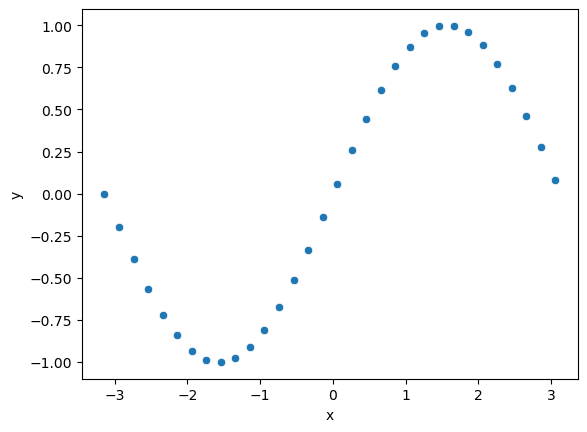

In [5]:
# model this function at coarse grain
Xt = np.arange(-3.14, 3.14, 0.2)
Yt = fun(Xt)
df = pd.DataFrame({'x':Xt, 'y':Yt})
sns.scatterplot(data=df, x='x', y='y')

In [6]:
# Load the dataset 
Xtt = torch.tensor(Xt.reshape(-1,1)).float() 
Ytt = torch.tensor(Yt.reshape(-1,1)).float()

## Now let's determine the architecture of our neural network model
Every time you run this, it reinitializes the model. If you name it something else and you have a GPU, you get have a GPU conflict error. In that case, just "del model" before you do this. 


In [7]:
# build the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(1, 20),
            nn.LeakyReLU(0.2),
            nn.Linear(20, 20),
            nn.LeakyReLU(0.2),
            nn.Linear(20, 1),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

# allocate the model on the GPU if available
model = NeuralNetwork().to(device)

# Allocate the data to the GPU if available.
# Note: The data and model must be on the same device. 
# If the model is on the GPU and the data is on the CPU (or vice versa), 
# a device mismatch error will occur.
Xtt = Xtt.to(device)
Ytt = Ytt.to(device)

print(model)

NeuralNetwork(
  (linear_stack): Sequential(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)


## Now let's train and test the model against the dataset. 

Epoch 1
-------------------------------
Test Average Loss: 0.2339722721662838

Epoch 2
-------------------------------
Test Average Loss: 0.2040080462160745

Epoch 3
-------------------------------
Test Average Loss: 0.18942097851686412

Epoch 4
-------------------------------
Test Average Loss: 0.17655694919085363

Epoch 5
-------------------------------
Test Average Loss: 0.16439582204293401

Epoch 6
-------------------------------
Test Average Loss: 0.15281224433510943

Epoch 7
-------------------------------
Test Average Loss: 0.14174132228185954

Epoch 8
-------------------------------
Test Average Loss: 0.1311223790207805

Epoch 9
-------------------------------
Test Average Loss: 0.12091016919112008

Epoch 10
-------------------------------
Test Average Loss: 0.1111142442750861



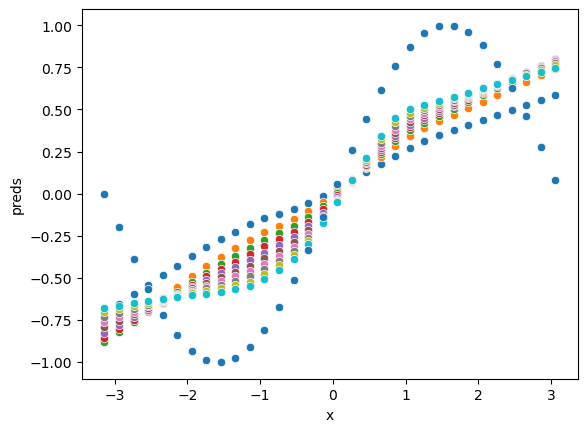

In [8]:
preds = train_and_test(Xtt, Ytt, model, learning_rate=1e-3, epochs=10, repeats=10, loss_fn=nn.MSELoss())

## Now let's visualize the final results.

<Axes: xlabel='x', ylabel='y'>

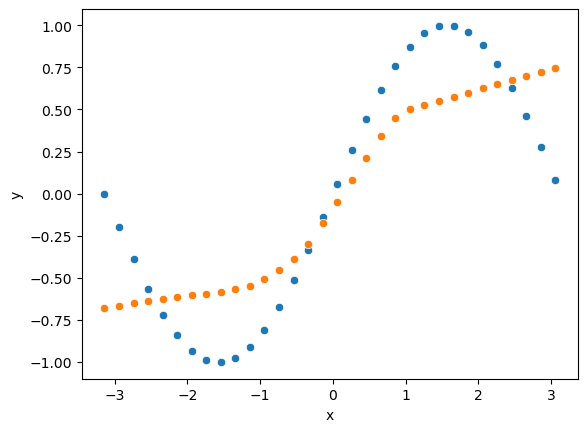

In [9]:
# Move the predictions back to the CPU if they are on GPU to store them in a DataFrame.
# DataFrames do not support tensors on the GPU, so the predictions must 
# be converted to CPU memory before assignment.
df['preds'] = preds.cpu()
sns.scatterplot(data=df, x='x', y='y')
sns.scatterplot(data=df, x='x', y='preds')

__Question 1:__ How many iterations does it take to reasonably train the neural network to the function?

Epoch 1
-------------------------------
Test Average Loss: 0.2654133022442693

Epoch 2
-------------------------------
Test Average Loss: 0.23246598369587446

Epoch 3
-------------------------------
Test Average Loss: 0.21708001750448602

Epoch 4
-------------------------------
Test Average Loss: 0.20705834629916353

Epoch 5
-------------------------------
Test Average Loss: 0.1992094834567979

Epoch 6
-------------------------------
Test Average Loss: 0.19249669432610972

Epoch 7
-------------------------------
Test Average Loss: 0.18628783625717915

Epoch 8
-------------------------------
Test Average Loss: 0.1803952970071805

Epoch 9
-------------------------------
Test Average Loss: 0.1749262936423861

Epoch 10
-------------------------------
Test Average Loss: 0.17001850001247476

Epoch 11
-------------------------------
Test Average Loss: 0.16531326249952372

Epoch 12
-------------------------------
Test Average Loss: 0.16067320548665975

Epoch 13
-------------------------------


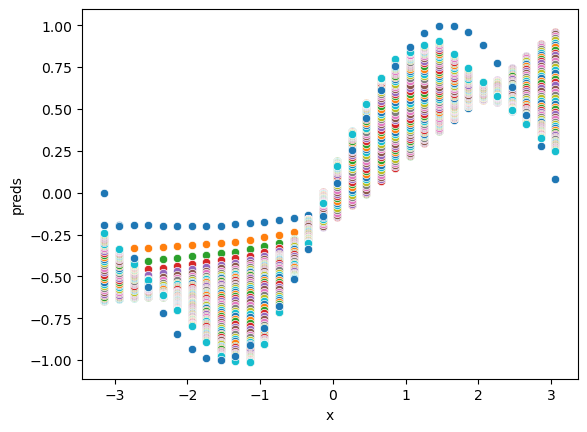

In [33]:
# Modify and run this to determine an answer. 
# build the neural network (again) to reinitialize it.
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(1, 20),
            nn.LeakyReLU(0.2),
            nn.Linear(20, 20),
            nn.LeakyReLU(0.2),
            nn.Linear(20, 1),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

# allocate the model on the GPU if available
model = NeuralNetwork().to(device)

# BEGIN SOLUTION
preds = train_and_test(Xtt, Ytt, model, learning_rate=1e-3, epochs=60, repeats=10, loss_fn=nn.MSELoss())
# END SOLUTION

<Axes: xlabel='x', ylabel='y'>

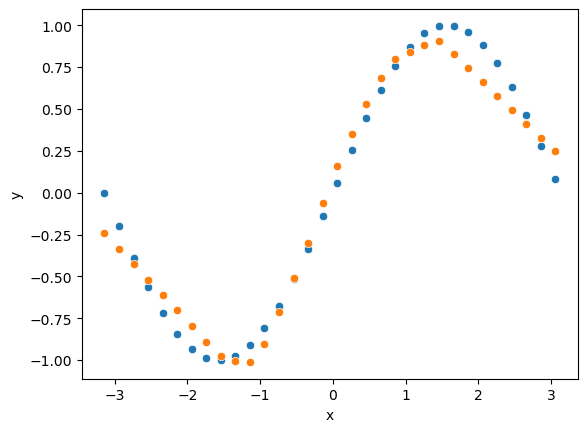

In [34]:
# Run this to visualize your results. 
df['preds'] = preds.cpu()
sns.scatterplot(data=df, x='x', y='y')
sns.scatterplot(data=df, x='x', y='preds')

*Your answer:* From what we're seeing after around 50-60 epochs the model is getting very close to fitting the function we are trying to model, and the test average loss between epochs is decreasing at a diminishing rate. 

__Question 2:__ What happens if you take your perfectly trained model and run it on data that isn't in range of the training set? 

In [35]:
# fill in blanks here and experiment! 
# BEGIN SOLUTION 
Xt2 = np.arange(-6,6,0.2)
# END SOLUTION 

<Axes: xlabel='x', ylabel='y'>

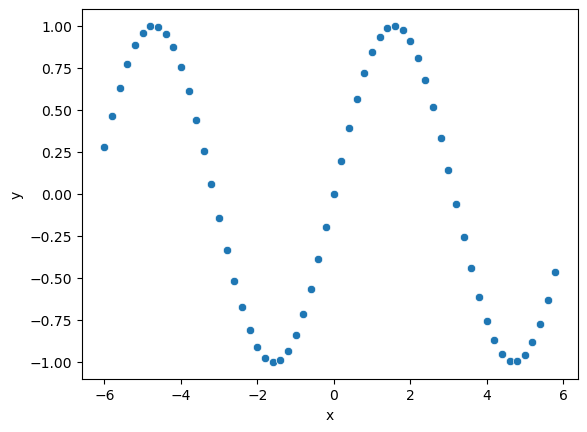

In [36]:
# This will plot your section of the function. 
Yt2 = fun(Xt2)
df2 = pd.DataFrame({'x':Xt2, 'y':Yt2})
sns.scatterplot(data=df2, x='x', y='y')

In [37]:
# This will test the trained model against this new domain. 
Xtt2 = torch.tensor(Xt2.reshape(-1,1)).float().to(device) 
Ytt2 = torch.tensor(Yt2.reshape(-1,1)).float().to(device)
preds2 = test_loop(Xtt2, Ytt2, model, nn.MSELoss())

Test Average Loss: 0.12375761075539533



<Axes: xlabel='x', ylabel='y'>

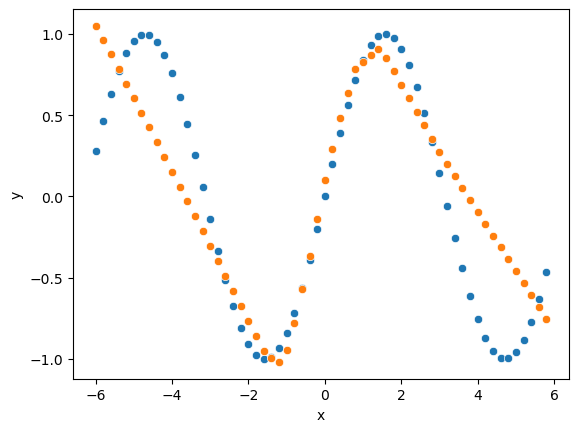

In [38]:
df2['preds'] = preds2.cpu()
sns.scatterplot(data=df2, x='x', y='y')
sns.scatterplot(data=df2, x='x', y='preds')

*Your answer:* When the range is extended the model has a much harder time predicting the curvature/trends outside the range it was trained on. We can see this in the graph, where after around -3.14 and +3.14, it stops aligning with the function's curve.

__Question 3:__ What happens if the width of the hidden layer is too narrow? Demonstrate below.

In [60]:
##### Modify and run this to determine an answer. 
# BEGIN SOLUTION
# build the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(1, 4),
            nn.LeakyReLU(0.2),
            nn.Linear(4, 4),
            nn.LeakyReLU(0.2),
            nn.Linear(4, 1),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

# allocate the model on the GPU if available
model = NeuralNetwork().to(device)
print(model)
# END SOLUTION

NeuralNetwork(
  (linear_stack): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=4, out_features=1, bias=True)
  )
)


Epoch 1
-------------------------------
Test Average Loss: 0.2524421740467915

Epoch 2
-------------------------------
Test Average Loss: 0.2096646725485698

Epoch 3
-------------------------------
Test Average Loss: 0.19173787669744513

Epoch 4
-------------------------------
Test Average Loss: 0.1830626429664335

Epoch 5
-------------------------------
Test Average Loss: 0.17822524041548604

Epoch 6
-------------------------------
Test Average Loss: 0.1752189272792748

Epoch 7
-------------------------------
Test Average Loss: 0.17301810027674946

Epoch 8
-------------------------------
Test Average Loss: 0.17118899111483188

Epoch 9
-------------------------------
Test Average Loss: 0.16952891672008263

Epoch 10
-------------------------------
Test Average Loss: 0.16805621676940063

Epoch 11
-------------------------------
Test Average Loss: 0.16677064536906983

Epoch 12
-------------------------------
Test Average Loss: 0.16559153135810334

Epoch 13
-------------------------------


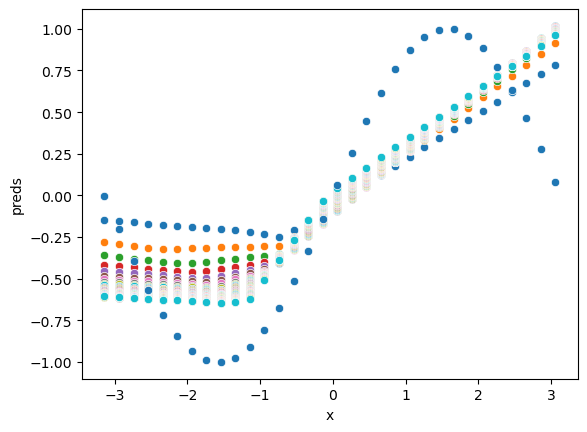

In [61]:
# Modify and run this to test your theories:
# BEGIN SOLUTION
preds = train_and_test(Xtt, Ytt, model, learning_rate=1e-3, epochs=50, repeats=10, loss_fn=nn.MSELoss())
# END SOLUTION

<Axes: xlabel='x', ylabel='y'>

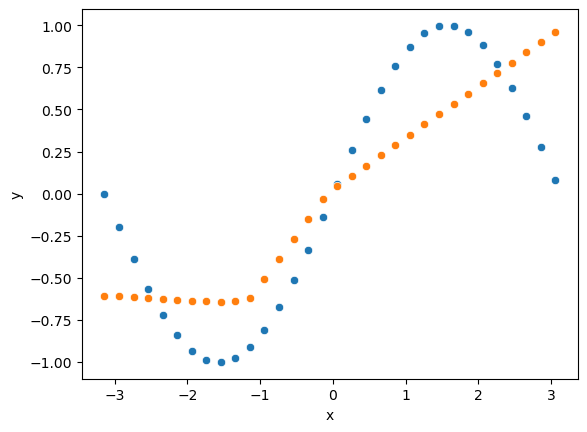

In [62]:
# Run this to visualize your results. 
df['preds'] = preds.cpu()
sns.scatterplot(data=df, x='x', y='y')
sns.scatterplot(data=df, x='x', y='preds')

*Your answer:* The model struggles to reduce the loss even from the very beginning, as the narrow hidden layers limit its ability to model complex relationships like a sine wave or non-linear curvature. We can see this also in the graph where the orange prediction points deviate significantly from the true blue points, even within the training range.



__Question 4:__ What happens if you take the demonstration from Question 3 and add another hidden layer of the same width? 

In [64]:
# Modify and run this to determine an answer. 
# BEGIN SOLUTION
# build the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(1, 4),
            nn.LeakyReLU(0.2),
            nn.Linear(4, 4),
            nn.LeakyReLU(0.2),
            nn.Linear(4, 4), # added hidden layer
            nn.LeakyReLU(0.2), # activation of the hidden layer with non-linearity
            nn.Linear(4, 1),
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

# allocate the model on the GPU if available
model = NeuralNetwork().to(device)
print(model)
# END SOLUTION

NeuralNetwork(
  (linear_stack): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=4, out_features=4, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=4, out_features=1, bias=True)
  )
)


Epoch 1
-------------------------------
Test Average Loss: 0.33488993254923116

Epoch 2
-------------------------------
Test Average Loss: 0.25792538542009424

Epoch 3
-------------------------------
Test Average Loss: 0.19746018807654764

Epoch 4
-------------------------------
Test Average Loss: 0.16498678868038041

Epoch 5
-------------------------------
Test Average Loss: 0.15021362764127844

Epoch 6
-------------------------------
Test Average Loss: 0.14268219180303277

Epoch 7
-------------------------------
Test Average Loss: 0.13784429378756613

Epoch 8
-------------------------------
Test Average Loss: 0.13394090663268798

Epoch 9
-------------------------------
Test Average Loss: 0.13067268113127284

Epoch 10
-------------------------------
Test Average Loss: 0.12762856036778736

Epoch 11
-------------------------------
Test Average Loss: 0.1245036575494396

Epoch 12
-------------------------------
Test Average Loss: 0.1215956732048653

Epoch 13
------------------------------

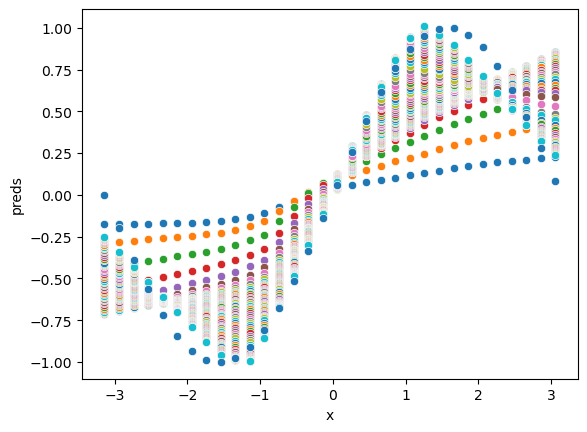

In [65]:
# Modify and run this to test your theories:
# BEGIN SOLUTION
preds = train_and_test(Xtt, Ytt, model, learning_rate=1e-3, epochs=60, repeats=10, loss_fn=nn.MSELoss())
# END SOLUTION

<Axes: xlabel='x', ylabel='y'>

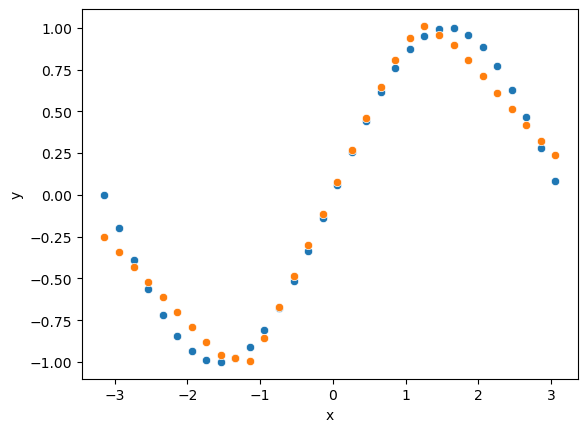

In [66]:
# Run this to visualize your results. 
df['preds'] = preds.cpu()
sns.scatterplot(data=df, x='x', y='y')
sns.scatterplot(data=df, x='x', y='preds')

*Your answer:* There is a visible improvement in the alignment of the predictions with the true sine wave.
The orange points are closer to the blue points, particularly in regions where the sine wave has sharper transitions, and where there are sharper transitions, the points are at least comparably closer to tracking those.